# How Predictable are Humans ? (ADAes Team) 

Wikispeedia is a game based on Wikipedia, where players are given a start and end article and they must reach their goal in the fastest time possible only by using Wikipedia hyperlinks.

This study aims at analysing players strategies in order to leverage out insightful conclusions about their navigational behaviour.

Table of content :  
1. [Can this behaviour be generalised](#1.-Can-this-behaviour-be-generalised-?) 
2. [What is the semantic meaning of these paths](#2.-What-is-the-semantic-meaning-of-these-paths-?)
3. [Is this strategy optimal?](#3.-Is-this-strategy-optimal-?)

In [2]:
# Import packages 
import pandas as pd
import networkx as nx
from helpers import *
import pickle
import os
from functools import reduce
import json
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import umap.umap_ as umap
import matplotlib.pyplot as plt
#import hdbscan
#from bertopic import BERTopic
from numpy import array, average
import math
from matplotlib.pyplot import figure

In [3]:
# Import data 

#Import DataFrames generated in Data_Engineering.ipynb
df_nodes_topics = pd.read_pickle('data/df_nodes_topics.pkl')
df_nodes = pd.read_pickle('data/df_nodes.pkl')
df_topics_general = pd.read_pickle('data/df_topics_general.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics_df.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics.pkl')
df_paths_finished = pd.read_pickle('data/df_paths_finished.pkl')
df_paths_unfinished = pd.read_pickle('data/df_paths_unfinished.pkl')

# Import NetworkX Graphs generated in Data_Engineering.ipynb
G_topics = nx.read_gpickle('data/G_topics.gpickle')
G_general_topics = nx.read_gpickle('data/G_general_topics.gpickle')
G_articles = nx.read_gpickle('data/G_articles.gpickle')

df_embeddings = pd.read_pickle('data/df_embeddings.pkl')

# Import useful dicts generated in Data_Engineering.ipynb
with open('data/closeness_dict.pkl','rb') as f:
    closeness_dict = pickle.load(f)
with open('data/closeness_topics_dict.pkl','rb') as f:
    closeness_topics_dict = pickle.load(f)  
with open('data/pagerank_topics_dict.pkl','rb') as f:
    pagerank_topics_dict = pickle.load(f)  

with open('data/pagerank_dict.pkl','rb') as f:
    pagerank_dict = pickle.load(f)  
    
with open('data/betweenness_dict.pkl','rb') as f:
    betweenness_dict = pickle.load(f)
with open('data/betweenness_topics_dict.pkl','rb') as f:
    betweenness_topics_dict = pickle.load(f)    

In [4]:
# We define the constatns for the analysis
OUT_DEGREE = 'out_degree'
CLOSENESS = 'closeness'
PAGERANK = 'pagerank'
BETWEENNESS = 'betweenness'
CENTRALITY_MEASURES = [OUT_DEGREE, CLOSENESS, PAGERANK, BETWEENNESS]

AVERAGE_PATH_LENGTH = round(df_paths_finished['path_length'].mean())

In [5]:
# We define the data schema for the analysis
class DataSchema :
    """This class defines the data schema for the analysis
    """

    START = 'start'
    TARGET = 'target'
    PATH = 'path'
    VISITS = 'visits'



# 1. Can this behaviour be generalised ?

## 1.1 Are the most central nodes the most visited ones ? 

### 1.1.1 What are the most central nodes ?

In [6]:
# Find other way to display the information more clearly 

In [7]:
# We sort and display the articles with the highest centrality measures
for measure in CENTRALITY_MEASURES:
    print('The articles with highest {} centrality are:'.format(measure))
    display(df_nodes.sort_values(by=measure, ascending=False)[[measure]].head(AVERAGE_PATH_LENGTH))

The articles with highest out_degree centrality are:


,out_degree
name,
United_States,1551
United_Kingdom,972
France,959
Europe,933
England,751
World_War_II,751


The articles with highest closeness centrality are:


,closeness
name,
United_States,0.590353
Europe,0.542750
United_Kingdom,0.541466
France,0.539805
Germany,0.524285
World_War_II,0.523446


The articles with highest pagerank centrality are:


,pagerank
name,
United_States,0.009566
France,0.006423
Europe,0.006340
United_Kingdom,0.006235
English_language,0.004865
Germany,0.004824


The articles with highest betweenness centrality are:


,betweenness
name,
United_States,0.094090
United_Kingdom,0.042384
England,0.032403
Europe,0.026992
Africa,0.024204
Germany,0.019409


### 1.1.2 What are the most visited nodes ? 

In [8]:
# We sort and display the most visited nodes 
print('The most visited nodes are :')
display(df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)[[DataSchema.VISITS]].head(AVERAGE_PATH_LENGTH))

The most visited nodes are :


,visits
name,
United_States,11991.0
Europe,5397.0
United_Kingdom,5021.0
England,4255.0
Earth,4095.0
Africa,3446.0


### 1.1.3 Are the most central nodes the most visited ones ?

In [9]:
# We add columns for the rank of each article in each centrality measure
for measure in CENTRALITY_MEASURES: 
    df_nodes[measure+'_rank'] = df_nodes[measure].rank(ascending=False)

In [10]:
# Compute some kind of metric (correlation) to explain choice of articles

In [11]:
# We sort and display the articles and their rank in each centrality measure
df_nodes = df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)
df_nodes[[DataSchema.VISITS, 'out_degree_rank', 'closeness_rank', 'betweenness_rank', 'pagerank_rank']].head(AVERAGE_PATH_LENGTH)

,visits,out_degree_rank,closeness_rank,betweenness_rank,pagerank_rank
name,,,,,
United_States,11991.0,1.0,1.0,1.0,1.0
Europe,5397.0,4.0,2.0,4.0,3.0
United_Kingdom,5021.0,2.0,3.0,2.0,4.0
England,4255.0,5.5,10.0,3.0,8.0
Earth,4095.0,49.0,56.0,11.0,35.0
Africa,3446.0,20.0,23.0,5.0,20.0


As we can see, the most visited nodes also perfom strongly on centrality measures. This confirms our intuition about players' strategy and the fact that they have a tendency to visit more central nodes.

Moreover, we can observe that the betweenness rank is the one that is the most similar to the visits of the players. This actually makes perfect sense as betweenness centrality is a measure of the number of times a node acts as a bridge along the shortest path between two other nodes. Therefore, we observe a high tendency of the players to visit nodes that are central in the shortest path they are trying to achieve.

## 1.2 What is the evolution of the centrality of the nodes visited in the path ?

In [12]:
# We define a function to get the k most played games 
def get_top_k_games(df_paths_finished, k):
    df_top_k = (
        df_paths_finished[[DataSchema.START, DataSchema.TARGET, DataSchema.PATH]]
        .groupby([DataSchema.START, DataSchema.TARGET])
        .count()
        .sort_values(by=DataSchema.PATH, axis=0, ascending=False)[:k]
    )
    top_k_games = df_top_k.index
    return top_k_games

In [13]:
# We define a function to find how many different players have played certain games 
def get_number_players(df_paths_finished, top_k_games):
    top_start = [i[0] for i in top_k_games]
    top_target = [i[1] for i in top_k_games]
    top_paths = list(zip(top_start, top_target))

    df_pruned = df_paths_finished.merge(
        pd.DataFrame(top_paths, columns=[DataSchema.START, DataSchema.TARGET]),
        how="inner",
        on=[DataSchema.START, DataSchema.TARGET],
    )
    return df_pruned.hashedIpAddress.nunique()

In [14]:
# We define a function to plot the  average evolution of a centrality measure for the top k paths 
def plot_average_evolution(df_paths_finished, df_nodes, k, measure):
    top_k_games = get_top_k_games(df_paths_finished, k)
    num_rows = math.floor(math.sqrt(k))
    num_cols = k // num_rows + 1
    figure, axis = plt.subplots(num_rows, num_cols)

    for i, game in enumerate(top_k_games):
        df_games = df_paths_finished[
            [DataSchema.START, DataSchema.TARGET, DataSchema.PATH]
        ]
        mask = (df_games[DataSchema.START] == game[0]) & (
            df_games[DataSchema.TARGET] == game[1]
        )
        df_games = df_games[mask]
        df_games["path_measure"] = df_games[DataSchema.PATH].apply(
            lambda l: [df_nodes.loc[elem][measure] for elem in l]
        )
        xs, ys, l, u = get_value_evolution(list(df_games["path_measure"]))
        ax = axis[i % num_rows, i // num_rows]
        ax.plot(xs, ys)
        ax.fill_between(xs, l, u, alpha=0.2)

        ax.set_title(game[0] + " to " + game[1], fontsize=15)

    figure.suptitle(
        "Average evolution of {} centrality for the top {} paths".format(measure, k),
        fontsize=20,
    )
    figure.set_size_inches(18.5, 10.5)
    figure.tight_layout()

In [15]:
# Add number of paths averaged for each subplot 

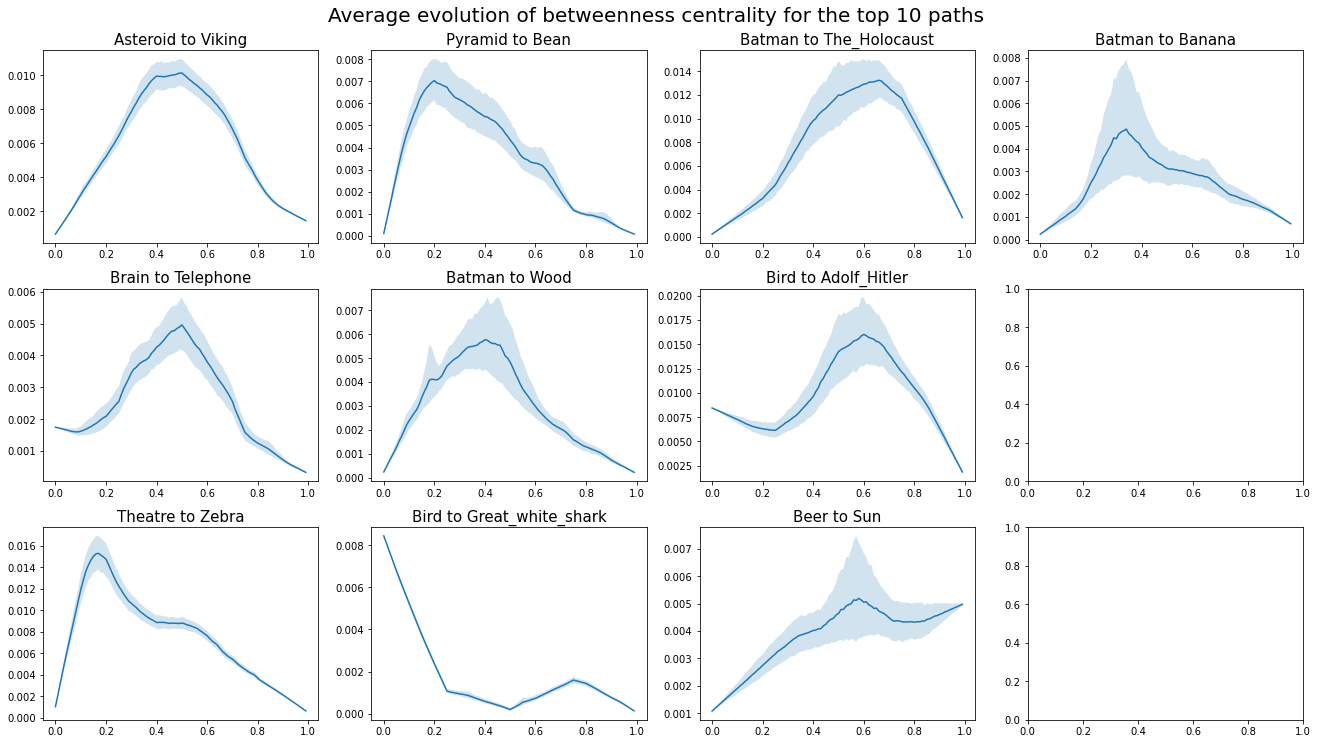

In [16]:
plot_average_evolution(df_paths_finished, df_nodes, 10, BETWEENNESS)

In [17]:
# We emphasize statistical significance based on how many players are involved in this study 
print('The number of unique players to have participated in this study is :', get_number_players(df_paths_finished, get_top_k_games(df_paths_finished, 10)))

The number of unique players to have participated in this study is : 2693


This study realised above further confirms our intution about players' strategy. We can clearly observe the evolution of the centrality measure along the path, and we see that players first move towards central nodes before focusing back on the target. 

This conclusion draws it's statistical significance from the confidence intervals of the curves as each curve was obtained by averaging many paths played. Moreover, 2693 players were involved in this study. 
Both those arguments make a solid statement that this behaviour is generalisable as we observe a great number of players converging towards the same strategy.

# 2. What is the semantic meaning of these paths ?

## 2.1 Are the players getting closer to the goal according to the shortest path metric ?


In [18]:
# We define the distance metric as the shortest path distance from point to the end article

def get_shortest_path(df_shortest_paths, start, end):
    pass
def get_shortest_path(G,start,end):
    return nx.shortest_path(G,start,end)

In [19]:
# Plot the evolution of the metric as we progress through the path

## 2.2 Does shortest path reflect semantic closeness/similarity ?

In [20]:
df_embeddings

,file_name,docs,clean_text,embeddings
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,copyright áedán mac gabráin 2007 schools wiki...,"[0.04089818894863129, -0.00878914725035429, -0..."
1,%C3%85land,#copyright\n\nÅland\n\n2007 Schools Wikiped...,copyright åland 2007 schools wikipedia select...,"[0.060515306890010834, -0.026957755908370018, ..."
2,%C3%89douard_Manet,#copyright\n\nÉdouard Manet\n\n2007 Schools...,copyright édouard manet 2007 schools wikipedi...,"[0.08456774055957794, 0.04743683338165283, 0.0..."
3,%C3%89ire,#copyright\n\nÉire\n\n2007 Schools Wikipedi...,copyright éire 2007 schools wikipedia selecti...,"[0.06309432536363602, -0.012940289452672005, 0..."
4,%C3%93engus_I_of_the_Picts,#copyright\n\nÓengus I of the Picts\n\n2007...,copyright óengus picts 2007 schools wikipedia...,"[0.02952096424996853, 0.0008616832201369107, 0..."
...,...,...,...,...
4599,Zirconium,#copyright\n\nZirconium\n\n2007 Schools Wik...,copyright zirconium 2007 schools wikipedia se...,"[0.03291991353034973, 0.011462809517979622, -0..."
4600,Zoroaster,#copyright\n\nZoroaster\n\n2007 Schools Wik...,copyright zoroaster 2007 schools wikipedia se...,"[0.05689842253923416, 0.03792918846011162, -0...."
4601,Zuid-Gelders,#copyright\n\nZuid-Gelders\n\n2007 Schools ...,copyright zuidgelders 2007 schools wikipedia ...,"[0.10174541920423508, 0.01555624045431614, -0...."
4602,Zulu,#copyright\n\nZulu\n\n2007 Schools Wikipedi...,copyright zulu 2007 schools wikipedia selecti...,"[0.014475343748927116, 0.017465412616729736, -..."


In [21]:
# Embed all article pages and retrieve topics

def embed_articles(df_articles,model):
    pass

In [22]:
# Compute cosine similarity between embedded vectors to yield semantic closeness

# This function will compute similarities between all page hops and the target article using transformers cos_sim  
def compute_cosine_similarity(df_embeddings,list_of_articles, target_article):
    df_path = df_embeddings[df_embeddings.file_name.apply(lambda x : x in list_of_articles+[target_article])]
    target_vector = df_path[df_path.file_name == target_article]['embeddings'].iloc[0]
    list_of_vectors = [df_path[df_path.file_name == article]['embeddings'].iloc[0] for article in list_of_articles]
    return cos_sim(array(list_of_vectors).astype(float),array(target_vector).astype(float)).numpy()


In [110]:
# Plot the evolution of the semantic closeness as we progress through the path 

k=12
top_k_games = get_top_k_games(df_paths_finished, k)
top_k_games_paths = []
for pair in set(top_k_games):
    top_k_games_paths.append(get_shortest_path(G_articles,pair[0],pair[1]))


similarities = []

for i in range(k):
    list_of_articles = top_k_games_paths[i][:-1]
    target_article = top_k_games_paths[i][-1]    
    similarities.append(compute_cosine_similarity(df_embeddings,list_of_articles, target_article))


In [106]:
similarities

[<generator object <genexpr> at 0x000001A114A77F90>,
 <generator object <genexpr> at 0x000001A11493DE40>,
 <generator object <genexpr> at 0x000001A11493D900>,
 <generator object <genexpr> at 0x000001A1133660B0>,
 <generator object <genexpr> at 0x000001A114B0C2E0>,
 <generator object <genexpr> at 0x000001A114B0C200>,
 <generator object <genexpr> at 0x000001A114B0C430>,
 <generator object <genexpr> at 0x000001A114B0C4A0>,
 <generator object <genexpr> at 0x000001A114B0C5F0>,
 <generator object <genexpr> at 0x000001A114B0C510>,
 <generator object <genexpr> at 0x000001A114B0C660>,
 <generator object <genexpr> at 0x000001A114B0C6D0>]

## 2.3 Is the player getting semantically closer to the goal ?

In [25]:
top_k_games_paths# Are the players getting semantically closer to the destination by each hop they take

[['Asteroid', '1_Ceres', 'Paris', 'Viking'],
 ['Batman', 'Chemistry', 'World_War_II', 'The_Holocaust'],
 ['Cat', 'Evolution', 'Computer'],
 ['Theatre', 'India', 'Extinction', 'Zebra'],
 ['Bird', 'Penguin', 'Orca', 'Great_white_shark'],
 ['Beer', 'Water', 'Sun'],
 ['Batman', 'Scotland', 'Atlantic_Ocean', 'Argentina', 'Banana'],
 ['Bird', 'Parrot', 'Adolf_Hitler'],
 ['Cat', 'Genealogy', 'Internet', 'Microsoft'],
 ['Brain', 'Biology', '19th_century', 'Telephone'],
 ['Pyramid', 'California', 'Fruit', 'Bean'],
 ['Batman', 'Chemistry', 'Fire', 'Wood']]

In [26]:
# Plot the evolution of the semantic closeness from each hop to the target page as we progress through the path

In [27]:
# Observe and draw conclusion on players' behaviour

# 3. Is this strategy optimal ? 

## 3.1 Is this strategy the one that yields the most winner paths ? 

In [28]:
# Is this strategy the one that yields the most winner paths?

In [29]:
# Here compute same procedure to loosing games 

In [30]:
# Plot evolution of centrality on shortest path 

In [31]:
# Compute overall success rate of the strategy

# This function filters out functions
def get_path_strategy(startegy, list_all_paths):
    pass

# In this case, we intend on feeding the function with already filtered paths that follow the strategy of interest
def success_rate(list_winner_paths, list_looser_paths):
    pass

In [36]:
# Wrap up and draw final conclusions about predictability of human behaviour
